In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

## One-layer conv encoder and decoder


In [2]:
class ConvEncoder(nn.Module):
    def __init__(self, in_channels, token_dim):
        """
        Args:
            in_channels: Number of input channels (e.g., 3 for RGB).
            token_dim: Dimensionality of each token.
        """
        super().__init__()
        self.token_dim = token_dim
        
        # Convolutional feature extractor (2 layers)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, token_dim, kernel_size=2, stride=2, padding=0),  # Further reduce spatial dimensions
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv(x)  # Shape: (batch, token_dim, H', W')
        x = x.flatten(start_dim=2).transpose(1, 2)  # Reshape to (batch, n_tokens, token_dim)
        return x  # (batch, n_tokens, token_dim)

class ConvDecoder(nn.Module):
    def __init__(self, token_dim, out_channels, output_size):
        """
        Args:
            token_dim: Dimensionality of each token.
            out_channels: Number of channels in output image.
            output_size: Tuple of (H, W) for output image.
        """
        super().__init__()
        self.token_dim = token_dim
        self.output_size = output_size
        
        # Calculate the reduced dimensions after encoder's convolutions
        self.h_reduced = output_size[0] // 2  # Divided by 4 because of two stride-2 convolutions
        self.w_reduced = output_size[1] // 2

        # Deconvolutional layers to match the encoder's conv layers
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(token_dim, out_channels, kernel_size=2, stride=2, padding=0),  # Match encoder's first conv
        )

    def forward(self, x):
        batch_size = x.shape[0]
        # Reshape to match the dimensions expected by deconv
        x = x.transpose(1, 2).reshape(batch_size, self.token_dim, self.h_reduced, self.w_reduced)
        x = self.deconv(x)  # Apply deconvolution
        return x

# Full Autoencoder Model
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels, token_dim, output_size):
        super().__init__()
        self.encoder = ConvEncoder(in_channels, token_dim)
        self.decoder = ConvDecoder(token_dim, in_channels, output_size)

    def forward(self, x):
        tokens = self.encoder(x)
        recon = self.decoder(tokens)
        return tokens, recon

In [13]:
def train_conv(token_dim, num_epochs=10):
    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST
    ])

    # Load the MNIST dataset
    dataset = MNIST("../data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

    # Initialize the model
    img_channels = 1  # MNIST images are grayscale
    img_size = (28, 28)
    model = ConvAutoencoder(in_channels=img_channels, token_dim=token_dim, output_size=img_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    loss_list = []
    for epoch in range(num_epochs):
        for batch_idx, (data, _) in enumerate(dataloader):
            # Forward pass
            tokens, recon = model(data)
            
            # Compute loss
            loss = criterion(recon, data)
            loss_list.append(loss.item())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch_idx % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(dataloader)}], Loss: {loss.item()}')

    print("Training complete.") 
    return loss_list

In [5]:
loss3 = train_conv(token_dim=3)

Epoch [1/10], Step [0/938], Loss: 1.1633
Epoch [1/10], Step [100/938], Loss: 0.7972
Epoch [1/10], Step [200/938], Loss: 0.2989
Epoch [1/10], Step [300/938], Loss: 0.1820
Epoch [1/10], Step [400/938], Loss: 0.1522
Epoch [1/10], Step [500/938], Loss: 0.1314
Epoch [1/10], Step [600/938], Loss: 0.1186
Epoch [1/10], Step [700/938], Loss: 0.1052
Epoch [1/10], Step [800/938], Loss: 0.1075
Epoch [1/10], Step [900/938], Loss: 0.0994
Epoch [2/10], Step [0/938], Loss: 0.0943
Epoch [2/10], Step [100/938], Loss: 0.0854
Epoch [2/10], Step [200/938], Loss: 0.0664
Epoch [2/10], Step [300/938], Loss: 0.0521
Epoch [2/10], Step [400/938], Loss: 0.0330
Epoch [2/10], Step [500/938], Loss: 0.0214
Epoch [2/10], Step [600/938], Loss: 0.0190
Epoch [2/10], Step [700/938], Loss: 0.0180
Epoch [2/10], Step [800/938], Loss: 0.0176
Epoch [2/10], Step [900/938], Loss: 0.0169
Epoch [3/10], Step [0/938], Loss: 0.0149
Epoch [3/10], Step [100/938], Loss: 0.0161
Epoch [3/10], Step [200/938], Loss: 0.0169
Epoch [3/10], Ste

In [7]:
loss4 = train_conv(token_dim=4)

Epoch [1/10], Step [0/938], Loss: 1.6743
Epoch [1/10], Step [500/938], Loss: 0.1097
Epoch [2/10], Step [0/938], Loss: 0.0322
Epoch [2/10], Step [500/938], Loss: 0.0180
Epoch [3/10], Step [0/938], Loss: 0.0154
Epoch [3/10], Step [500/938], Loss: 0.0082
Epoch [4/10], Step [0/938], Loss: 0.0019
Epoch [4/10], Step [500/938], Loss: 0.0001
Epoch [5/10], Step [0/938], Loss: 0.0000
Epoch [5/10], Step [500/938], Loss: 0.0000
Epoch [6/10], Step [0/938], Loss: 0.0000
Epoch [6/10], Step [500/938], Loss: 0.0000
Epoch [7/10], Step [0/938], Loss: 0.0000
Epoch [7/10], Step [500/938], Loss: 0.0000
Epoch [8/10], Step [0/938], Loss: 0.0000
Epoch [8/10], Step [500/938], Loss: 0.0000
Epoch [9/10], Step [0/938], Loss: 0.0000
Epoch [9/10], Step [500/938], Loss: 0.0000
Epoch [10/10], Step [0/938], Loss: 0.0000
Epoch [10/10], Step [500/938], Loss: 0.0000
Training complete.


In [10]:
loss16 = train_conv(token_dim=16)

Epoch [1/10], Step [0/938], Loss: 1.9085
Epoch [1/10], Step [500/938], Loss: 0.0130
Epoch [2/10], Step [0/938], Loss: 0.0008
Epoch [2/10], Step [500/938], Loss: 0.0000
Epoch [3/10], Step [0/938], Loss: 0.0000
Epoch [3/10], Step [500/938], Loss: 0.0000
Epoch [4/10], Step [0/938], Loss: 0.0000
Epoch [4/10], Step [500/938], Loss: 0.0000
Epoch [5/10], Step [0/938], Loss: 0.0000
Epoch [5/10], Step [500/938], Loss: 0.0000
Epoch [6/10], Step [0/938], Loss: 0.0000
Epoch [6/10], Step [500/938], Loss: 0.0000
Epoch [7/10], Step [0/938], Loss: 0.0000
Epoch [7/10], Step [500/938], Loss: 0.0000
Epoch [8/10], Step [0/938], Loss: 0.0000
Epoch [8/10], Step [500/938], Loss: 0.0000
Epoch [9/10], Step [0/938], Loss: 0.0000
Epoch [9/10], Step [500/938], Loss: 0.0000
Epoch [10/10], Step [0/938], Loss: 0.0000
Epoch [10/10], Step [500/938], Loss: 0.0000
Training complete.


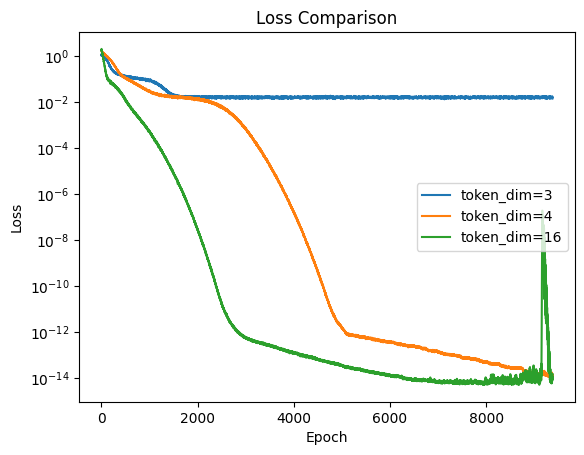

In [11]:
# plot comparison loss with log scale
import matplotlib.pyplot as plt
plt.plot(loss3, label='token_dim=3')
plt.plot(loss4, label='token_dim=4')
plt.plot(loss16, label='token_dim=16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Comparison')
plt.legend()
plt.show()


## Two-layer conv encoder and decoder


In [12]:

class ConvEncoder(nn.Module):
    def __init__(self, in_channels, token_dim):
        """
        Args:
            in_channels: Number of input channels (e.g., 3 for RGB).
            token_dim: Dimensionality of each token.
        """
        super().__init__()
        self.token_dim = token_dim
        
        # Convolutional feature extractor (2 layers)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=2, stride=2, padding=0),  # Reduce spatial dimensions
            nn.ReLU(),
            nn.Conv2d(64, token_dim, kernel_size=2, stride=2, padding=0),  # Further reduce spatial dimensions
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv(x)  # Shape: (batch, token_dim, H', W')
        x = x.flatten(start_dim=2).transpose(1, 2)  # Reshape to (batch, n_tokens, token_dim)
        return x  # (batch, n_tokens, token_dim)

class ConvDecoder(nn.Module):
    def __init__(self, token_dim, out_channels, output_size):
        """
        Args:
            token_dim: Dimensionality of each token.
            out_channels: Number of channels in output image.
            output_size: Tuple of (H, W) for output image.
        """
        super().__init__()
        self.token_dim = token_dim
        self.output_size = output_size
        
        # Calculate the reduced dimensions after encoder's convolutions
        self.h_reduced = output_size[0] // 4  # Divided by 4 because of two stride-2 convolutions
        self.w_reduced = output_size[1] // 4

        # Deconvolutional layers to match the encoder's conv layers
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(token_dim, 64, kernel_size=2, stride=2, padding=0),  # Match encoder's second conv
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2, padding=0),  # Match encoder's first conv
        )

    def forward(self, x):
        batch_size = x.shape[0]
        # Reshape to match the dimensions expected by deconv
        x = x.transpose(1, 2).reshape(batch_size, self.token_dim, self.h_reduced, self.w_reduced)
        x = self.deconv(x)  # Apply deconvolution
        return x

In [14]:
loss16 = train_conv(token_dim=16)

Epoch [1/10], Step [0/938], Loss: 1.239169716835022
Epoch [1/10], Step [500/938], Loss: 0.0022910453844815493
Epoch [2/10], Step [0/938], Loss: 0.001141059910878539
Epoch [2/10], Step [500/938], Loss: 0.0005345380050130188
Epoch [3/10], Step [0/938], Loss: 0.00020386600226629525
Epoch [3/10], Step [500/938], Loss: 0.0001292116503464058
Epoch [4/10], Step [0/938], Loss: 8.864206029102206e-05
Epoch [4/10], Step [500/938], Loss: 8.019628876354545e-05
Epoch [5/10], Step [0/938], Loss: 0.0002816396881826222
Epoch [5/10], Step [500/938], Loss: 0.00011056078074034303
Epoch [6/10], Step [0/938], Loss: 6.683304673060775e-05
Epoch [6/10], Step [500/938], Loss: 3.49953661498148e-05
Epoch [7/10], Step [0/938], Loss: 3.706311326823197e-05
Epoch [7/10], Step [500/938], Loss: 6.0673915868392214e-05
Epoch [8/10], Step [0/938], Loss: 0.0005535405944101512
Epoch [8/10], Step [500/938], Loss: 3.044017830688972e-05
Epoch [9/10], Step [0/938], Loss: 2.6447318305145018e-05
Epoch [9/10], Step [500/938], Loss

In [15]:
loss32 = train_conv(token_dim=32)

Epoch [1/10], Step [0/938], Loss: 1.0645034313201904
Epoch [1/10], Step [500/938], Loss: 0.0005532716168090701
Epoch [2/10], Step [0/938], Loss: 0.00024279544595628977
Epoch [2/10], Step [500/938], Loss: 0.00016412188415415585
Epoch [3/10], Step [0/938], Loss: 0.00015749846352264285
Epoch [3/10], Step [500/938], Loss: 8.198047726182267e-05
Epoch [4/10], Step [0/938], Loss: 8.66327973199077e-05
Epoch [4/10], Step [500/938], Loss: 6.995145668042824e-05
Epoch [5/10], Step [0/938], Loss: 4.457234899746254e-05
Epoch [5/10], Step [500/938], Loss: 3.9398943044943735e-05
Epoch [6/10], Step [0/938], Loss: 3.948799712816253e-05
Epoch [6/10], Step [500/938], Loss: 3.985431612818502e-05
Epoch [7/10], Step [0/938], Loss: 2.815363222907763e-05
Epoch [7/10], Step [500/938], Loss: 4.057676051161252e-05
Epoch [8/10], Step [0/938], Loss: 2.5777679184102453e-05
Epoch [8/10], Step [500/938], Loss: 0.00020326102094259113
Epoch [9/10], Step [0/938], Loss: 3.238620047341101e-05
Epoch [9/10], Step [500/938], 

In [16]:
loss4 = train_conv(token_dim=4)

Epoch [1/10], Step [0/938], Loss: 1.081368327140808
Epoch [1/10], Step [500/938], Loss: 0.06251183152198792
Epoch [2/10], Step [0/938], Loss: 0.05069386214017868
Epoch [2/10], Step [500/938], Loss: 0.04768889397382736
Epoch [3/10], Step [0/938], Loss: 0.04734071344137192
Epoch [3/10], Step [500/938], Loss: 0.049910519272089005
Epoch [4/10], Step [0/938], Loss: 0.040777768939733505
Epoch [4/10], Step [500/938], Loss: 0.042152151465415955
Epoch [5/10], Step [0/938], Loss: 0.03956121206283569
Epoch [5/10], Step [500/938], Loss: 0.04334394261240959
Epoch [6/10], Step [0/938], Loss: 0.03633187338709831
Epoch [6/10], Step [500/938], Loss: 0.03994312509894371
Epoch [7/10], Step [0/938], Loss: 0.037462394684553146
Epoch [7/10], Step [500/938], Loss: 0.040517374873161316
Epoch [8/10], Step [0/938], Loss: 0.04701736941933632
Epoch [8/10], Step [500/938], Loss: 0.048225753009319305
Epoch [9/10], Step [0/938], Loss: 0.04208081588149071
Epoch [9/10], Step [500/938], Loss: 0.04461575672030449
Epoch 

In [18]:
loss15 = train_conv(token_dim=15)

Epoch [1/10], Step [0/938], Loss: 0.9870079755783081
Epoch [1/10], Step [500/938], Loss: 0.00589247141033411
Epoch [2/10], Step [0/938], Loss: 0.0019816483836621046
Epoch [2/10], Step [500/938], Loss: 0.0010384100023657084
Epoch [3/10], Step [0/938], Loss: 0.0009428173652850091
Epoch [3/10], Step [500/938], Loss: 0.0007841781480237842
Epoch [4/10], Step [0/938], Loss: 0.0007793717668391764
Epoch [4/10], Step [500/938], Loss: 0.0005933633074164391
Epoch [5/10], Step [0/938], Loss: 0.0005924898432567716
Epoch [5/10], Step [500/938], Loss: 0.0005558247212320566
Epoch [6/10], Step [0/938], Loss: 0.0005870863096788526
Epoch [6/10], Step [500/938], Loss: 0.0004872122372034937
Epoch [7/10], Step [0/938], Loss: 0.0004915812169201672
Epoch [7/10], Step [500/938], Loss: 0.0003844782477244735
Epoch [8/10], Step [0/938], Loss: 0.0004778450820595026
Epoch [8/10], Step [500/938], Loss: 0.0003936032298952341
Epoch [9/10], Step [0/938], Loss: 0.00038300006417557597
Epoch [9/10], Step [500/938], Loss: 

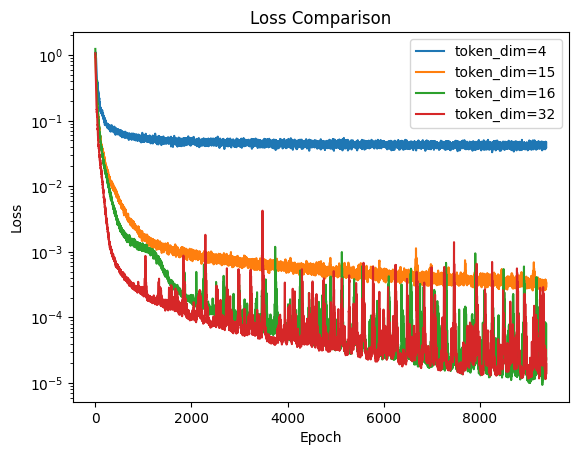

In [19]:
# plot comparison loss with log scale
import matplotlib.pyplot as plt
plt.plot(loss4, label='token_dim=4')
plt.plot(loss15, label='token_dim=15')
plt.plot(loss16, label='token_dim=16')
plt.plot(loss32, label='token_dim=32')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Comparison')
plt.legend()
plt.show()